---
 reading in file /home/sirfuser/devel/buildVM/sources/SIRF/data/examples/MR/simulated_MR_2D_cartesian_Grappa2.h5...
Close Figure 1 window to continue...


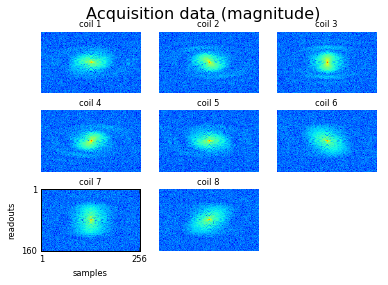

---
 reconstructing...

Close Figure 1 window to continue...


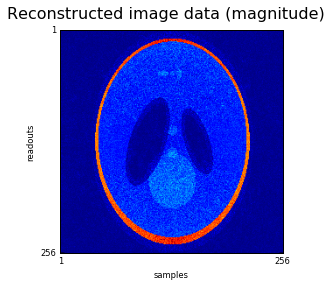

Close Figure 1 window to continue...


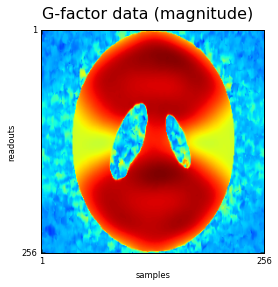

0

In [3]:
#'''
#Demonstrates GRAPPA reconstruction of undersampled data. 
#See function grappa_basic.py for a simpler example.
#
#Pre-requisites:
# 1) This Python script needs to be able to access a listening gadgetron.
#    On the Virtual Machine, gadgetron is installed and the user just needs
#    to type 'gadgetron' in a terminal window.
#    On standalone systems, the user will need to have installed ISMRMRD
#   and gadgetron code.
#
# 2) An input data file from a GRAPPA MRI acquisition in the ISMRMRD format.
#    Example GRAPPA datasets:
#    a) 'meas_MID00108_FID57249_test_2D_2x.dat' is 
#       available from https://www.ccppetmr.ac.uk/downloads
#       This is in the manufacturer's raw data format and needs to be
#       converted to ISMRMRD format using 'siemens_to_ismrmrd'.
#       This executable is installed on the Virtual Machine.
#
#    b) A simulated ISMRMRD h5 file is available as default
#
#Usage:
#  grappa_detail.py [--help | options]
#
#Options:
#  -f <file>, --file=<file>    raw data file
#                              [default: simulated_MR_2D_cartesian_Grappa2.h5]
#  -p <path>, --path=<path>    path to data files, defaults to data/examples/MR
#                              subfolder of SIRF root folder
#'''
#
## CCP PETMR Synergistic Image Reconstruction Framework (SIRF).
## Copyright 2015 - 2017 Rutherford Appleton Laboratory STFC.
## Copyright 2015 - 2017 University College London.
## Copyright 2015 - 2017 Physikalisch-Technische Bundesanstalt.
##
## This is software developed for the Collaborative Computational
## Project in Positron Emission Tomography and Magnetic Resonance imaging
## (http://www.ccppetmr.ac.uk/).
##
## Licensed under the Apache License, Version 2.0 (the "License");
##   you may not use this file except in compliance with the License.
##   You may obtain a copy of the License at
##       http://www.apache.org/licenses/LICENSE-2.0
##   Unless required by applicable law or agreed to in writing, software
##   distributed under the License is distributed on an "AS IS" BASIS,
##   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
##   See the License for the specific language governing permissions and
##   limitations under the License.

__version__ = '0.1.0'
from docopt import docopt


# import engine module
from pGadgetron import *

# process command-line options
data_file = 'simulated_MR_2D_cartesian_Grappa2.h5' 
data_path = petmr_data_path('mr')

from pUtilities import show_3D_array

    
# Acquisitions will be read from this HDF file
input_file = existing_filepath(data_path, data_file)
    
# Initially we create a container that points to the h5 file. Data is
# not read from file until the gadgetron is called using
# the 'process' method.
    
# Create an acquisition container of type pGadgetron.AcquisitionData
print('---\n reading in file %s...' % input_file)
acq_data = AcquisitionData(input_file)
    
    
# Pre-process this input data using three preparation gadgets
# from gadgetron.
# List gadgets to use (not all may be required for this test data).
prep_gadgets = ['NoiseAdjustGadget', 'AsymmetricEchoAdjustROGadget', \
                                'RemoveROOversamplingGadget' ]
    
# Call gadgetron by using the 'process' method. This runs the gadgets
# specified in prep_gadgets, returning an instance
# of an mGadgetron.AcquisitionsContainer
preprocessed_data = acq_data.process(prep_gadgets)
    
# Extract sorted k-space, permute dimensions and display
acq_array = preprocessed_data.as_array(0)
[ns,nc,nro] = preprocessed_data.dimensions() # [nx ncoil ny]
acq_array = numpy.transpose(acq_array,(1,0,2))
title = 'Acquisition data (magnitude)'

%matplotlib inline
show_3D_array(acq_array, power = 0.2, \
                  suptitle = title, title_size = 16, \
                  xlabel = 'samples', ylabel = 'readouts', label = 'coil')
            
    
# Perform reconstruction of the preprocessed data.
    
# 1) Create a recon object for the desired reconstruction.
    
# In this demo, the recon object is created using the class
# Reconstructor(). A simpler class is available in the SIRF code
# for a GRAPPA reconstruction:
#   recon = CartesianGRAPPAReconstructor()
    
recon_gadgets = ['AcquisitionAccumulateTriggerGadget',
    'BucketToBufferGadget', 
    'GenericReconCartesianReferencePrepGadget', 
    'GRAPPA:GenericReconCartesianGrappaGadget', 
    'GenericReconFieldOfViewAdjustmentGadget', 
    'GenericReconImageArrayScalingGadget', 
    'ImageArraySplitGadget'
    ]
    
recon = Reconstructor(recon_gadgets)
    
    
# 2) The GRAPPA gadget can compute G-factors in addition to
# reconstructed images. We can set a gadget property as below if the gadget
# has been identified with a label. In the above list of recon_gadgets,
# the 4th is labelled 'GRAPPA' and we can use this label as below:
recon.set_gadget_property('GRAPPA', 'send_out_gfactor', True)
    
# If the chain had been set using
# recon = CartesianGRAPPAReconstructor(), an alternative method
# would be available:
#  recon.compute_gfactors(True)
    
    
# 3) set the reconstruction input to be the data we just preprocessed.
recon.set_input(preprocessed_data)
    
# 4) Run the reconstruction using 'process' to call gadgetron.
print('---\n reconstructing...\n')
recon.process()
    
# Output
    
# Reconstructed data sits in memory. We need to first get data
# for both the reconstructed images and g-factors, before extracting the
# data as Python arrays.
    
# Get image and gfactor data as objects of type mGadgetron.ImageData
# (Note this syntax may change in the future with the addition of a
#  method '.get_gfactor'.)
image_data = recon.get_output('image')
gfact_data = recon.get_output('gfactor')
    
# Return as Python matrices the data pointed to by the containers.
# Note the image data is complex.
image_as_3D_array = image_data.as_array()
maxv = numpy.amax(abs(image_as_3D_array))
title = 'Reconstructed image data (magnitude)'


show_3D_array(abs(image_as_3D_array), \
                suptitle = title, title_size = 16, \
                xlabel = 'samples', ylabel = 'readouts', label = 'slice', \
                scale = (0, maxv))
            
            
gfactor_as_3D_array = gfact_data.as_array();
maxv = numpy.amax(abs(gfactor_as_3D_array))
title = 'G-factor data (magnitude)'
show_3D_array(abs(gfactor_as_3D_array),
                suptitle = title, title_size = 16, \
                xlabel = 'samples', ylabel = 'readouts', label = 'slice', \
                scale = (0, maxv))
